In [1]:
#############
# LIBRARIES #
#############

import os
# Current working directory
curr_dir = os.getcwd()
data_dir = os.path.join('data')
notebook_dir = os.path.join('notebooks')
figures_dir = os.path.join('figures')
analyses_dir = os.path.join('analyses')
project_dir = os.path.join('..')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, Lipinski
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumHDonors, NumHAcceptors

from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu

target = 'CASP2'

In [2]:
# Opening the preprocessed data
activity_df = pd.read_csv(os.path.join(project_dir, data_dir, 'CASP2_bioactivity_data_preprocessed.csv'))
activity_df.head()

,molecule_chembl_id,canonical_smiles,standard_value,bioavtivity_class
0,CHEMBL366927,CCCCCCN(C)CC(=O)C(CC(=O)O)NC(=O)C(CC)n1cc(C(C)...,10.0,active
1,CHEMBL179503,CCCCCN(C)CC(=O)C(CC(=O)O)NC(=O)C(CC)n1cc(C(C)(...,10.0,active
2,CHEMBL206435,O=C1NC(=O)c2ccccc2C1=O,1530.0,intermediate
3,CHEMBL203709,COc1ccccc1NC(=O)CCC(=O)Nc1ccc2c(c1)C(=O)C(=O)N...,537.0,active
4,CHEMBL438969,O=C(CCC(=O)N1CCCCC1)Nc1ccc2c(c1)C(=O)C(=O)NC2=O,231.0,active


### Lipinski Rule-of-Five (Ro5) for evaluating the "druglikeness" of compounds.

"Druglikeness is based on four steps --Pharmacokinetic Profile:

- **A**bsorption: Describes how the drug moves from the site of administration to the site of action.
- **D**istribution: Describes the journey of the drug through the bloodstream to various tissues of the body.
- **M**etabolism: Describes the process that breaks down the drug.
- **E**xcretion: Describes the removal of the drug from the body.

| ![image](https://www.researchgate.net/profile/Imane-Almi/publication/323343296/figure/fig6/AS:614315828731914@1523475715214/Lipinskis-Rule-of-five.png) |
| :--: |
| Lipinski Rule-of-Five (Ro5) for evaluating the "druglikeness" of compounds |

In [3]:
# Writing a function to calculate Lipinski descriptors
def get_lipinski_descriptors(df):
    """
    Function takes in a preprocessed dataframe and returns a dataframe with the following descriptors:
    Molecular Weight (MW)
    Molecular LogP (LogP)
    Hydrogen Bond Donors (NumHDonors)
    Hydrogen Bond Acceptors (NumHAcceptors)
    """
    all_canonical_smiles = np.array(activity_df.canonical_smiles)
    chembl_ids = np.array(activity_df.molecule_chembl_id)
    chem_dict = {chembl_ids[i]: all_canonical_smiles[i] for i in range(len(chembl_ids))}
# Converting arrays to a dictionary
    chem_dict = {chembl_ids[i]: all_canonical_smiles[i] for i in range(len(chembl_ids))}
    temp_df = []
    col_names = ['molecule_chembl_id', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors']
    for key, smile in chem_dict.items():
        mol_weight = float(MolWt(Chem.MolFromSmiles(smile)))
        mol_logp = float(MolLogP(Chem.MolFromSmiles(smile)))
        h_donors = float(NumHDonors(Chem.MolFromSmiles(smile)))
        h_acceptors = float(NumHAcceptors(Chem.MolFromSmiles(smile)))
        
        array = [key, mol_weight, mol_logp, h_donors, h_acceptors]
        temp_df.append(array)
        
    df = pd.DataFrame(temp_df, columns=col_names)
    return df

In [4]:
lipinski_descriptors = get_lipinski_descriptors(activity_df)
lipinski_descriptors.head()

,molecule_chembl_id,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL366927,612.172,3.25792,3.0,11.0
1,CHEMBL179503,598.145,2.86782,3.0,11.0
2,CHEMBL206435,175.143,0.13930,1.0,3.0
3,CHEMBL203709,395.371,1.50530,3.0,6.0
4,CHEMBL438969,357.366,0.87050,2.0,5.0


In [5]:
lipinski_descriptors.dtypes

molecule_chembl_id     object
MW                    float64
LogP                  float64
NumHDonors            float64
NumHAcceptors         float64
dtype: object

In [6]:
# Now we can merge the two dataframes

df_combined = pd.merge(activity_df, lipinski_descriptors, on='molecule_chembl_id', how='left')
df_combined.head()

,molecule_chembl_id,canonical_smiles,standard_value,bioavtivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL366927,CCCCCCN(C)CC(=O)C(CC(=O)O)NC(=O)C(CC)n1cc(C(C)...,10.0,active,612.172,3.25792,3.0,11.0
1,CHEMBL179503,CCCCCN(C)CC(=O)C(CC(=O)O)NC(=O)C(CC)n1cc(C(C)(...,10.0,active,598.145,2.86782,3.0,11.0
2,CHEMBL206435,O=C1NC(=O)c2ccccc2C1=O,1530.0,intermediate,175.143,0.13930,1.0,3.0
3,CHEMBL203709,COc1ccccc1NC(=O)CCC(=O)Nc1ccc2c(c1)C(=O)C(=O)N...,537.0,active,395.371,1.50530,3.0,6.0
4,CHEMBL438969,O=C(CCC(=O)N1CCCCC1)Nc1ccc2c(c1)C(=O)C(=O)NC2=O,231.0,active,357.366,0.87050,2.0,5.0


In [7]:
df_combined.standard_value.describe()

count        70.000000
mean      19405.228571
std       34019.808465
min          10.000000
25%         287.750000
50%        1960.000000
75%       13480.250000
max      100000.000000
Name: standard_value, dtype: float64

Text(0.5, 1.0, 'Distribution of Standard Values')

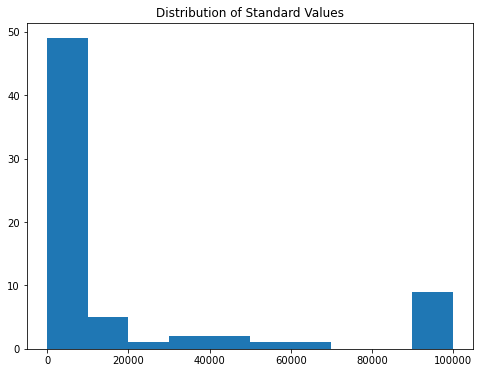

In [8]:
# Let's look at the distribution of the standard value
fig, ax = plt.subplots(figsize=(8, 6))

ax = plt.hist(df_combined.standard_value)
plt.title('Distribution of Standard Values')

In [9]:
# Converting IC50 values to pIC50 --we will convert IC50 to the negative logarithmic scale which is essentially -log10(IC50) to allow IC50 data to be more uniformly distributed. 
# - We convert from nM to M by multiplying by 10^-9
# - We take the molar value and apply the negative logarithm to get pIC50
# - However, in order to prevent negative values we'll cap the value at 10^9


def transform_ic50_to_pIC50(df):
    """
    Function takes in a dataframe and returns a dataframe with the following columns:
    pIC50
    """
    df['standard_value_M'] = df.standard_value.apply(lambda x: x / 10**9) # nM to M
    df['standard_value_M'] = df['standard_value_M'].apply(lambda x: 100000000 if x > 100000000 else x) # Capping the standard_value at 10^9 to prevent negative values
    df['pIC50'] = df['standard_value_M'].apply(lambda x: -np.log10(x)) # -log10(IC50)
    df.drop('standard_value', axis=1, inplace=True)
    df.drop('standard_value_M', axis=1, inplace=True)
    return df


In [10]:
df_tranformed = transform_ic50_to_pIC50(df_combined)

In [11]:
df_tranformed.head()

,molecule_chembl_id,canonical_smiles,bioavtivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL366927,CCCCCCN(C)CC(=O)C(CC(=O)O)NC(=O)C(CC)n1cc(C(C)...,active,612.172,3.25792,3.0,11.0,8.000000
1,CHEMBL179503,CCCCCN(C)CC(=O)C(CC(=O)O)NC(=O)C(CC)n1cc(C(C)(...,active,598.145,2.86782,3.0,11.0,8.000000
2,CHEMBL206435,O=C1NC(=O)c2ccccc2C1=O,intermediate,175.143,0.13930,1.0,3.0,5.815309
3,CHEMBL203709,COc1ccccc1NC(=O)CCC(=O)Nc1ccc2c(c1)C(=O)C(=O)N...,active,395.371,1.50530,3.0,6.0,6.270026
4,CHEMBL438969,O=C(CCC(=O)N1CCCCC1)Nc1ccc2c(c1)C(=O)C(=O)NC2=O,active,357.366,0.87050,2.0,5.0,6.636388


Text(0.5, 1.0, 'Distribution of Standard Values')

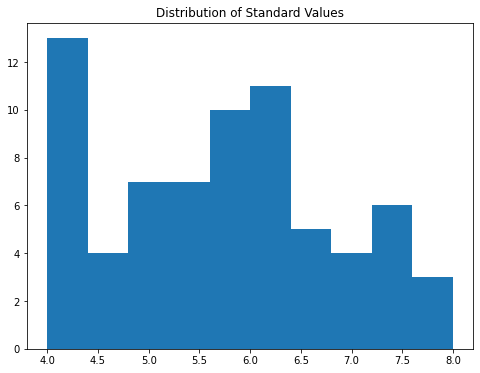

In [12]:
# Checking the distribution of the pIC50 values
fig, ax = plt.subplots(figsize=(8, 6))
ax = plt.hist(df_tranformed.pIC50)
plt.title('Distribution of Standard Values')

In [13]:
df_combined.pIC50.describe()

count    70.000000
mean      5.698202
std       1.131274
min       4.000000
25%       4.870360
50%       5.707767
75%       6.552811
max       8.000000
Name: pIC50, dtype: float64

In [14]:
# Removing the "intermediate" bioactivity class
df_final = df_combined[df_combined.bioavtivity_class != 'intermediate']
df_final.head()

,molecule_chembl_id,canonical_smiles,bioavtivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL366927,CCCCCCN(C)CC(=O)C(CC(=O)O)NC(=O)C(CC)n1cc(C(C)...,active,612.172,3.25792,3.0,11.0,8.000000
1,CHEMBL179503,CCCCCN(C)CC(=O)C(CC(=O)O)NC(=O)C(CC)n1cc(C(C)(...,active,598.145,2.86782,3.0,11.0,8.000000
3,CHEMBL203709,COc1ccccc1NC(=O)CCC(=O)Nc1ccc2c(c1)C(=O)C(=O)N...,active,395.371,1.50530,3.0,6.0,6.270026
4,CHEMBL438969,O=C(CCC(=O)N1CCCCC1)Nc1ccc2c(c1)C(=O)C(=O)NC2=O,active,357.366,0.87050,2.0,5.0,6.636388
5,CHEMBL202971,O=C(O)CCC(=O)Nc1ccc2c(c1)C(=O)C(=O)NC2=O,active,290.231,-0.05740,3.0,5.0,6.066007


In [15]:
df_final.to_csv(os.path.join(project_dir, data_dir, f'{target}_bioactive_data_LIP_descriptors.csv'), index=False)

In [16]:
df_final.dtypes

molecule_chembl_id     object
canonical_smiles       object
bioavtivity_class      object
MW                    float64
LogP                  float64
NumHDonors            float64
NumHAcceptors         float64
pIC50                 float64
dtype: object

### EDA (Chemical Space Analysis) via Lipinski descriptors

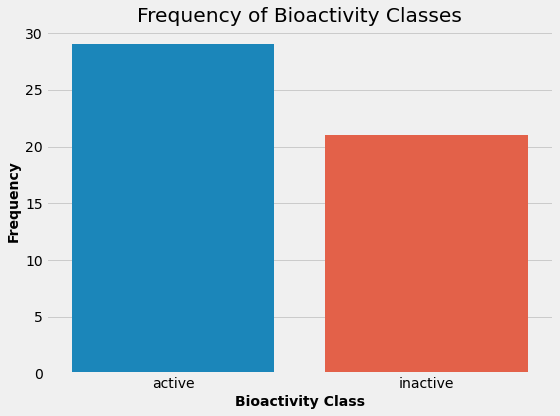

In [17]:
# Frequency of the 2 activity classes

plt.style.use('fivethirtyeight')
fig, ax  = plt.subplots(figsize=(8, 6))

ax = sns.countplot(data=df_final, x='bioavtivity_class')
plt.title('Frequency of Bioactivity Classes')
ax.set_xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(project_dir, figures_dir, 'bioactivity_class_frequency.png'), dpi=300)
plt.show()


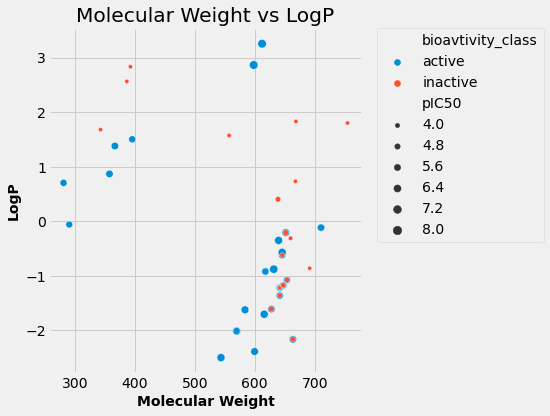

In [18]:
# Scatter plot of MW vs LogP
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(8, 6))

ax = sns.scatterplot(data=df_final, x='MW', y='LogP', hue='bioavtivity_class', size='pIC50')
plt.title('Molecular Weight vs LogP')
ax.set_xlabel('Molecular Weight', fontsize=14, fontweight='bold')
ax.set_ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig(os.path.join(project_dir, figures_dir, 'MW_vs_LogP.png'), dpi=300)
plt.show()

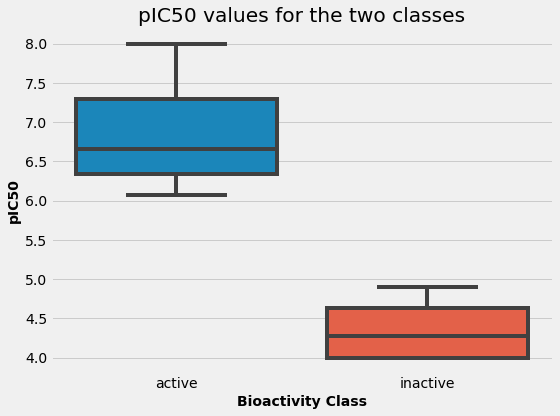

In [19]:
# Looking at pIC50 values for the two classes
fig, ax = plt.subplots(figsize=(8, 6))

ax = sns.boxplot(data=df_final, x='bioavtivity_class', y='pIC50')
plt.title('pIC50 values for the two classes')
ax.set_xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
ax.set_ylabel('pIC50', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(project_dir, figures_dir, 'pIC50_values.png'), dpi=300)
plt.show()


In [20]:
# Statitical analysis of the two classes | Mann-Whitney U test
# Function to test the statistical significance of the two activity classes for each of the descriptors

def wmw_test(df, descriptor):
    """
    Function takes in a dataframe and two columns and returns the Mann-Whitney U test and the p-value
    """
    seed(1)
    active = df[df['bioavtivity_class'] == 'active'][descriptor]
    inactive = df[df['bioavtivity_class'] == 'inactive'][descriptor]
    stat, pval = mannwhitneyu(active, inactive)
    
    alpha = 0.05
    
    if pval < alpha:
        interpretation = 'There is a significant difference between the two classes; reject the null hypothesis'
    else:
        interpretation = 'There is no significant difference between the two classes; fail to reject the null hypothesis'
    results = {'Descriptor': descriptor, 'Statistics': stat, 'P-value': pval, 'Interpretation': interpretation}
    results_df = pd.DataFrame(results, index=[0])
    
    return results_df


In [21]:
wmw_test(df_final, 'pIC50')

,Descriptor,Statistics,P-value,Interpretation
0,pIC50,609.0,2.056024e-09,There is a significant difference between the ...


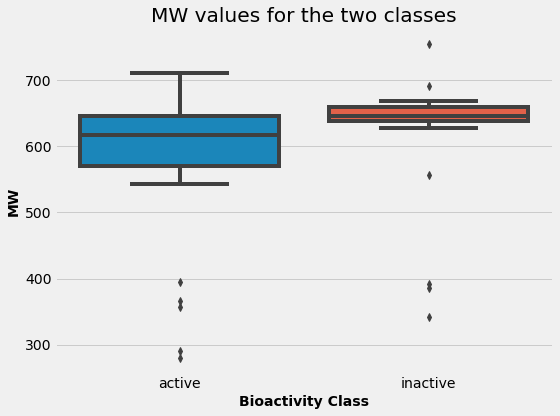

In [22]:
# Looking at MW values for the two classes
fig, ax = plt.subplots(figsize=(8, 6))

ax = sns.boxplot(data=df_final, x='bioavtivity_class', y='MW')
plt.title('MW values for the two classes')
ax.set_xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
ax.set_ylabel('MW', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(project_dir, figures_dir, 'MW_values.png'), dpi=300)
plt.show()

In [23]:
wmw_test(df_final, 'MW')

,Descriptor,Statistics,P-value,Interpretation
0,MW,203.5,0.047918,There is a significant difference between the ...


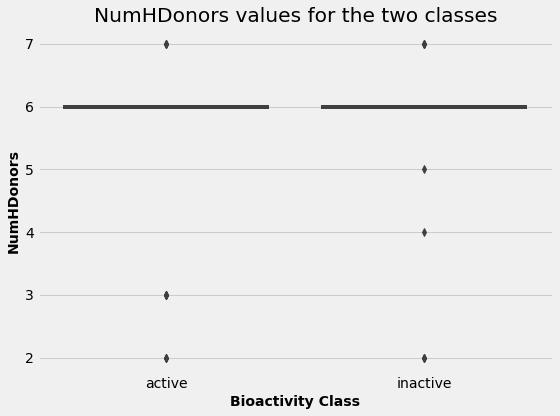

In [24]:
# Looking at NumHDonors values for the two classes
fig, ax = plt.subplots(figsize=(8, 6))

ax = sns.boxplot(data=df_final, x='bioavtivity_class', y='NumHDonors')
plt.title('NumHDonors values for the two classes')
ax.set_xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
ax.set_ylabel('NumHDonors', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(project_dir, figures_dir, 'NumHDonors_values.png'), dpi=300)
plt.show()

In [25]:
wmw_test(df_final, 'NumHDonors')

,Descriptor,Statistics,P-value,Interpretation
0,NumHDonors,293.5,0.809653,There is no significant difference between the...


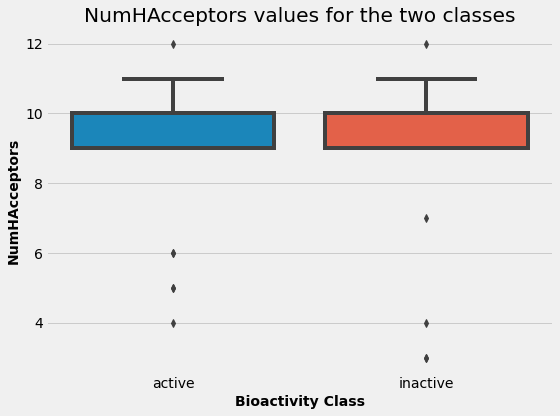

In [26]:
# Looking at NumHAcceptors values for the two classes
fig, ax = plt.subplots(figsize=(8, 6))

ax = sns.boxplot(data=df_final, x='bioavtivity_class', y='NumHAcceptors')
plt.title('NumHAcceptors values for the two classes')
ax.set_xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
ax.set_ylabel('NumHAcceptors', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(project_dir, figures_dir, 'NumHAcceptors_values.png'), dpi=300)
plt.show()

In [27]:
wmw_test(df_final, 'NumHAcceptors')

,Descriptor,Statistics,P-value,Interpretation
0,NumHAcceptors,284.0,0.678376,There is no significant difference between the...


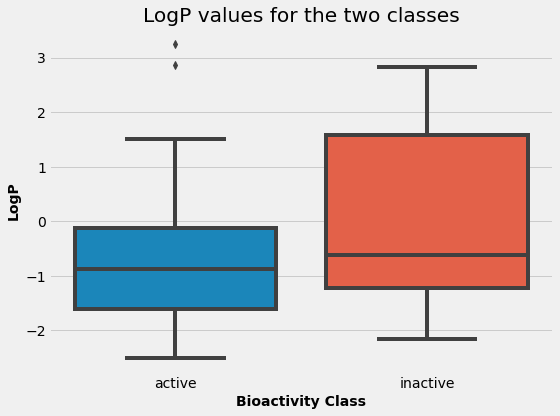

In [28]:
# Looking at LogP values for the two classes
fig, ax = plt.subplots(figsize=(8, 6))

ax = sns.boxplot(data=df_final, x='bioavtivity_class', y='LogP')
plt.title('LogP values for the two classes')
ax.set_xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
ax.set_ylabel('LogP', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(project_dir, figures_dir, 'LogP_values.png'), dpi=300)
plt.show()

In [29]:
wmw_test(df_final, 'LogP')

,Descriptor,Statistics,P-value,Interpretation
0,LogP,250.5,0.292798,There is no significant difference between the...


In [30]:
# Combining the results of the wmw test into a single dataframe
all_descriptors = ['pIC50', 'MW', 'NumHDonors', 'NumHAcceptors', 'LogP']
result_df = pd.DataFrame()

for d in all_descriptors:
        results_df = wmw_test(df_final, d)
        result_df = result_df.append(results_df, ignore_index=True)
        

/var/folders/6t/_k6kmr152jq69rjlrcg91mb00000gn/T/ipykernel_10660/3160741081.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(results_df, ignore_index=True)
/var/folders/6t/_k6kmr152jq69rjlrcg91mb00000gn/T/ipykernel_10660/3160741081.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(results_df, ignore_index=True)
/var/folders/6t/_k6kmr152jq69rjlrcg91mb00000gn/T/ipykernel_10660/3160741081.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(results_df, ignore_index=True)
/var/folders/6t/_k6kmr152jq69rjlrcg91mb00000gn/T/ipykernel_10660/3160741081.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

In [31]:
result_df.to_csv(os.path.join(project_dir, analyses_dir, 'statistical_analysis.csv'), index=False)